In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import wrangle
import prep
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

wrangle.py functions loaded successfully
acquire.py functions loaded successfully


# Import Prepared Zillow Data

In [2]:
## Assigning function
df = prep.prep_zillow_data()
## Checking for nulls
df.isna().sum()

bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
fips                            0
fullbathcnt                     0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
assessmentyear                  0
landtaxvaluedollarcnt           0
taxamount                       0
propertylandusetypeid           0
dtype: int64

In [3]:
## Applying our train_validate_test function to the dataframe to split and remove unneeded features for the models
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.train_validate_test(df)
X_train.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt
111,2.0,2.0,2.0,1766.0,2.0
1345,2.0,2.0,2.0,967.0,2.0
13768,1.0,2.0,1.0,1012.0,1.0
15147,2.5,5.0,2.5,2498.0,2.0
7249,1.0,0.0,1.0,482.0,1.0


In [4]:
## Applying scaler to scale our data
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.min_max_scale(X_train, X_validate, X_test)

In [5]:
X_train_scaled.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt
111,0.4,0.333333,0.250,0.338334,0.25
1345,0.4,0.333333,0.250,0.153935,0.25
13768,0.2,0.333333,0.000,0.164320,0.00
15147,0.5,0.833333,0.375,0.507270,0.25
7249,0.2,0.000000,0.000,0.042003,0.00


# KBest
- Here we're going to run all the features through our k best and return only the 5 best ones for our model

In [6]:
from sklearn.feature_selection import SelectKBest, f_regression

In [7]:
f_selector = SelectKBest(f_regression, k=5)

In [8]:
## we are running the scaled train data through kbest
f_selector = f_selector.fit(X_train_scaled, y_train.taxvaluedollarcnt)

In [9]:
## Transforming the data
X_train_reduced = f_selector.transform(X_train_scaled)
print(X_train.shape)
print(X_train_reduced.shape)

(11645, 5)
(11645, 5)


In [10]:
f_support = f_selector.get_support()
f_support

array([ True,  True,  True,  True,  True])

In [11]:
## Listing out the features so we can see which ones were returned
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
f_feature

['bathroomcnt',
 'bedroomcnt',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'fullbathcnt']

In [12]:
## Returning a scaled dataframe with only our best features
X_reduced_scaled = X_train_scaled.iloc[:, f_support]
X_reduced_scaled.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,fullbathcnt
111,0.4,0.333333,0.250,0.338334,0.25
1345,0.4,0.333333,0.250,0.153935,0.25
13768,0.2,0.333333,0.000,0.164320,0.00
15147,0.5,0.833333,0.375,0.507270,0.25
7249,0.2,0.000000,0.000,0.042003,0.00


# Takeaways
- The features that were selected were relatively consistent with our intial thoughts
- We anticipated that the bedroom count and square footage of the property would be important

# Recursive Feature Elimination
- Here we wanted to compare the RFE to KBest since RFE is typically more accurate
- We're keeping the K at 5 just to ensure consistency

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [14]:
## Assessing the RFE using a linear regression model
lm = LinearRegression()

rfe = RFE(lm, 5)

lm_X_rfe = rfe.fit_transform(X_train,y_train) 

In [15]:
## Here we want to filter through and return only the best features
mask = rfe.support_ 
rfe_features = X_train.columns[mask]
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 5 features: bathroomcnt, bedroomcnt, calculatedbathnbr, calculatedfinishedsquarefeet, fullbathcnt


# RFE Takeaways
- It appears that our RFE and KBest came to the same conclusion about our best features to use
- This will strengthen our argument when discussing best features to assess the model on

# Linear Regression Model - Training The Model

In [16]:
lm.fit(lm_X_rfe, y_train)

LinearRegression()

In [17]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression()
intercept:  [56628.38604184]
features:  Index(['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'fullbathcnt'],
      dtype='object')
coefficients:  [[  94351.07649936 -108290.0571259   -14256.46387687     338.98585949
   -14048.26277807]]


In [18]:
## Here we're going to add a column that will make property value predictions using the linear model
y_train['yhat_lm'] = lm.predict(lm_X_rfe)

y_train.head()

,taxvaluedollarcnt,yhat_lm
111,203113.0,570789.999342
1345,109028.0,299940.297608
13768,445279.0,249148.311440
15147,282241.0,534104.783423
7249,205628.0,286065.920161


In [19]:
## Checking the mean squared error of the model
RMSE_lm = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_lm))
RMSE_lm

394836.13048676855

In [20]:
r2_lm = lm.score(lm_X_rfe, y_train.taxvaluedollarcnt)

r2_lm

0.2765297324249697

In [21]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
output

'taxvaluedollarcnt = 5.663e+04 + 9.4e+04 * bathroomcnt + -1.08e+05 * bedroomcnt'

# Linear Regression Model - Validating The Model
- We came back and added the validate beneath the training just to maintain continuity and easier performance comparison

In [22]:
lm_X_rfe = rfe.fit_transform(X_validate,y_validate)
mask = rfe.support_ 
rfe_features = X_validate.columns[mask]
## Verifying same features returned as train
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 5 features: bathroomcnt, bedroomcnt, calculatedbathnbr, calculatedfinishedsquarefeet, fullbathcnt


In [23]:
## Same process as above, just with validate
y_validate['yhat_lm'] = lm.predict(lm_X_rfe).round(1)

y_validate.head()

,taxvaluedollarcnt,yhat_lm
3844,844184.0,540257.2
16451,625000.0,372329.7
6804,400000.0,204741.2
11288,300251.0,528077.8
15145,150312.0,290351.0


In [24]:
RMSE_lm = np.sqrt(mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.yhat_lm))
RMSE_lm

386958.2066632213

In [25]:
r2_lm = lm.score(lm_X_rfe, y_validate.taxvaluedollarcnt)

r2_lm

0.27627442603980634

In [26]:
output = "{} = {:.4} + {:.2} * {} + {:.3} * {}".format(
    y_train.columns[0],
    lm.intercept_[0],
    lm.coef_[0][0],
    rfe_features[0],
    lm.coef_[0][1],
    rfe_features[1],
)
output

'taxvaluedollarcnt = 5.663e+04 + 9.4e+04 * bathroomcnt + -1.08e+05 * bedroomcnt'

# Baseline Model vs Linear Regression

464203.11080032005
-2.220446049250313e-16


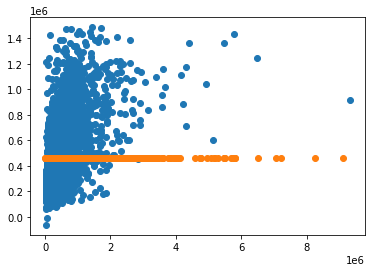

In [27]:
y_train['yhat_baseline'] = df['taxvaluedollarcnt'].mean()

# compute the RMSE
RMSE_bl = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_baseline))
print(RMSE_bl)

# no need to compute R-2 because it will be a 0! But we will demonstrate here:
evs = explained_variance_score(y_train.taxvaluedollarcnt, y_train.yhat_baseline)
print(evs)
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_lm, label='Linear Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

# Takeaways
- Our Linear Model is performing better than the baseline based on this graph, but we will want to compare it below to the Polynomial so we can get our MVP

# Polynomial Regression Model At 4 Degrees

In [28]:
from sklearn.preprocessing import PolynomialFeatures

poly_X_rfe = rfe.fit_transform(X_train,y_train)

## We're starting with 4 degrees as a rough starting point
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(poly_X_rfe)

poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0^2 x3',
 'x0^2 x4',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x2^2',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x3^2',
 'x0 x3 x4',
 'x0 x4^2',
 'x1^3',
 'x1^2 x2',
 'x1^2 x3',
 'x1^2 x4',
 'x1 x2^2',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x3^2',
 'x1 x3 x4',
 'x1 x4^2',
 'x2^3',
 'x2^2 x3',
 'x2^2 x4',
 'x2 x3^2',
 'x2 x3 x4',
 'x2 x4^2',
 'x3^3',
 'x3^2 x4',
 'x3 x4^2',
 'x4^3',
 'x0^4',
 'x0^3 x1',
 'x0^3 x2',
 'x0^3 x3',
 'x0^3 x4',
 'x0^2 x1^2',
 'x0^2 x1 x2',
 'x0^2 x1 x3',
 'x0^2 x1 x4',
 'x0^2 x2^2',
 'x0^2 x2 x3',
 'x0^2 x2 x4',
 'x0^2 x3^2',
 'x0^2 x3 x4',
 'x0^2 x4^2',
 'x0 x1^3',
 'x0 x1^2 x2',
 'x0 x1^2 x3',
 'x0 x1^2 x4',
 'x0 x1 x2^2',
 'x0 x1 x2 x3',
 'x0 x1 x2 x4',
 'x0 x1 x3^2',
 'x0 x1 x3 x4',
 'x0 x1 x4^2',
 'x0 x2^3',
 'x0 x2^2 x3',
 'x0 x2^2 x4',
 'x0

- Here were going to create a column and return all the predictions for the first polynomial model
- Then were going to compare it to the linear regression model and baseline

In [29]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly_1'] = lm_poly.predict(X_poly)

In [30]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly_1))
RMSE_poly

386880.6094870363

In [31]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_baseline,yhat_poly_1
111,203113.0,570789.999342,461477.599221,531743.182128
1345,109028.0,299940.297608,461477.599221,322777.038901
13768,445279.0,249148.311440,461477.599221,239489.333694
15147,282241.0,534104.783423,461477.599221,520145.317815
7249,205628.0,286065.920161,461477.599221,217689.643269


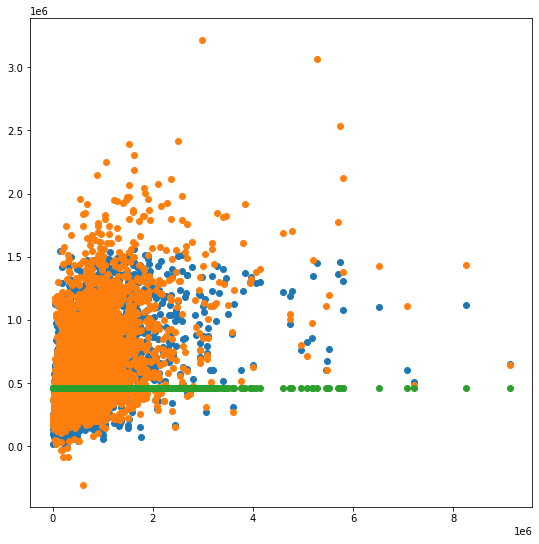

In [32]:
plt.figure(figsize=(9, 9))

plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_lm, label='Linear Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_poly_1, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

# Takeaways
- Both models were performing better than baseline but based on the points, the polynomial is actually going to be closest to that perfect 45 degree angle of the regression line
- At this point it's safe to assume that the Polynomial is going to be the right model to further build on with different versions of this model

# Polynomial Regression Model At 3 Degrees

In [33]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(poly_X_rfe)

In [34]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly_2'] = lm_poly.predict(X_poly)

In [35]:
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly_2))
RMSE_poly

385695.7510914246

In [36]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_baseline,yhat_poly_1,yhat_poly_2
111,203113.0,570789.999342,461477.599221,531743.182128,522776.975964
1345,109028.0,299940.297608,461477.599221,322777.038901,277784.513657
13768,445279.0,249148.311440,461477.599221,239489.333694,290255.343835
15147,282241.0,534104.783423,461477.599221,520145.317815,482630.654696
7249,205628.0,286065.920161,461477.599221,217689.643269,240903.658948


# Polynomial Regression Model At 2 Degrees

In [37]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(poly_X_rfe)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.taxvaluedollarcnt)
y_train['yhat_poly_3'] = lm_poly.predict(X_poly)
RMSE_poly = np.sqrt(mean_squared_error(y_train.taxvaluedollarcnt, y_train.yhat_poly_3))
RMSE_poly

387593.10865652846

In [38]:
y_train.head()

,taxvaluedollarcnt,yhat_lm,yhat_baseline,yhat_poly_1,yhat_poly_2,yhat_poly_3
111,203113.0,570789.999342,461477.599221,531743.182128,522776.975964,542259.756727
1345,109028.0,299940.297608,461477.599221,322777.038901,277784.513657,275107.143931
13768,445279.0,249148.311440,461477.599221,239489.333694,290255.343835,282980.764454
15147,282241.0,534104.783423,461477.599221,520145.317815,482630.654696,522958.769960
7249,205628.0,286065.920161,461477.599221,217689.643269,240903.658948,231981.958220


In [39]:
y_train['base_perc_error'] = ((y_train.taxvaluedollarcnt - y_train.yhat_baseline) / y_train.taxvaluedollarcnt) * 100
y_train.base_perc_error.sum()

-1233608.835842686

# Takeaways
- After assessing different degrees for the polynomial model, it appears that the model set to 4 and 3 degrees are pretty similar so we will run both against the validate compared to linear

# Polynomial Regression Model On Validate Set

In [40]:
val_poly_X_rfe = rfe.fit_transform(X_validate,y_validate) 

In [41]:
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(val_poly_X_rfe)

In [42]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_validate.taxvaluedollarcnt)
y_validate['yhat_poly1'] = lm_poly.predict(X_poly).round(1)

In [43]:
RMSE_poly = np.sqrt(mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.yhat_poly1))
RMSE_poly

375845.46568807366

In [44]:
y_validate.head()

,taxvaluedollarcnt,yhat_lm,yhat_poly1
3844,844184.0,540257.2,460329.7
16451,625000.0,372329.7,344088.9
6804,400000.0,204741.2,248718.0
11288,300251.0,528077.8,511631.1
15145,150312.0,290351.0,312132.6


In [45]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(val_poly_X_rfe)
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_validate.taxvaluedollarcnt)
y_validate['yhat_poly2'] = lm_poly.predict(X_poly).round(1)
RMSE_poly = np.sqrt(mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.yhat_poly2))
RMSE_poly

378401.9376576725

In [46]:
y_validate.head()

,taxvaluedollarcnt,yhat_lm,yhat_poly1,yhat_poly2
3844,844184.0,540257.2,460329.7,487499.7
16451,625000.0,372329.7,344088.9,349068.0
6804,400000.0,204741.2,248718.0,256764.7
11288,300251.0,528077.8,511631.1,505649.3
15145,150312.0,290351.0,312132.6,322356.1


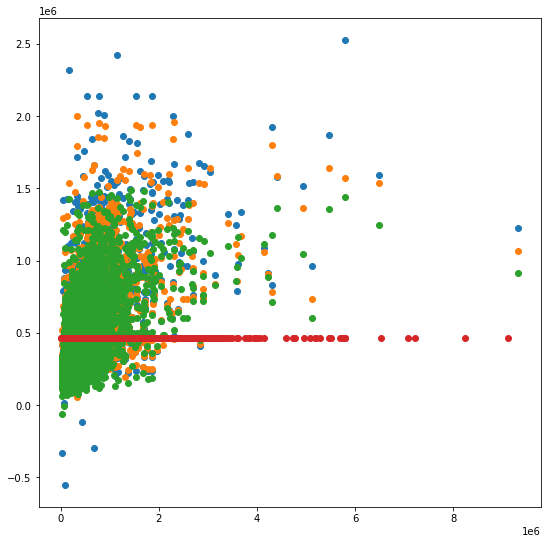

In [47]:
plt.figure(figsize=(9, 9))
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_poly1, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_poly2, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.yhat_lm, label='Linear Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')

# Linear vs Poly On Validate
- After comparing the 4 models on the validate datasets, the model set to 4 degrees is the best one because it improved on the validate, where the model at 3 degrees did not
- Polynomial at 4 degress is our MVP

# MVP - Poly At Degree 4

In [48]:
test_poly_X_rfe = rfe.fit_transform(X_test,y_test) 

In [49]:
poly = PolynomialFeatures(degree=4)
X_poly = poly.fit_transform(test_poly_X_rfe)

In [50]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_test.taxvaluedollarcnt)
y_test['yhat_poly'] = lm_poly.predict(X_poly).round(1)

In [51]:
RMSE_poly = np.sqrt(mean_squared_error(y_test.taxvaluedollarcnt, y_test.yhat_poly))
RMSE_poly

370452.4242366546

In [52]:
y_test.head()

,taxvaluedollarcnt,yhat_poly
12052,314788.0,354865.9
14120,272103.0,399942.1
1251,1148056.0,628566.7
17699,52274.0,262532.8
18034,238108.0,422888.6


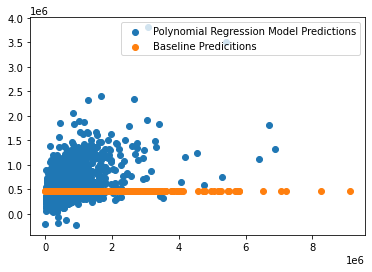

In [60]:
plt.scatter(y_test.taxvaluedollarcnt, y_test.yhat_poly, label='Polynomial Regression Model Predictions', marker='o')
plt.scatter(y_train.taxvaluedollarcnt, y_train.yhat_baseline, label='Baseline Predicitions', marker='o')
plt.legend()
plt.show()

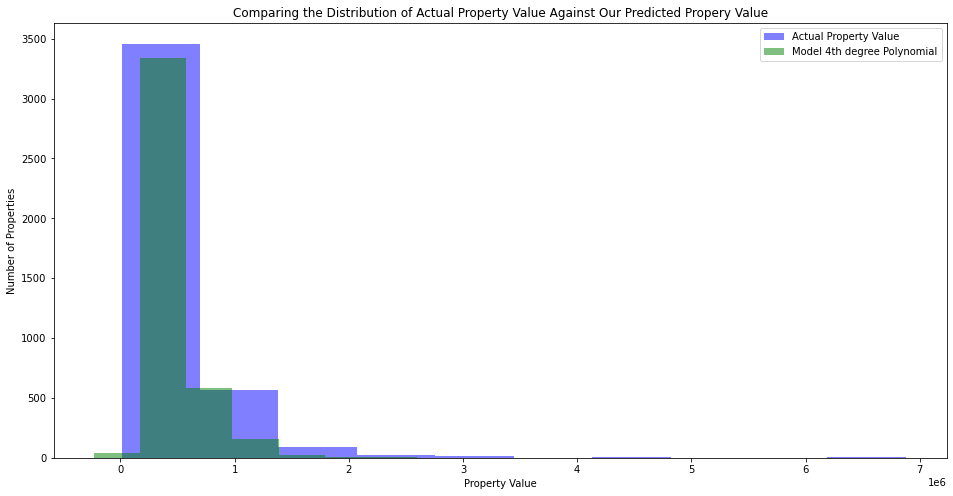

In [59]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_test.taxvaluedollarcnt, color='blue', alpha=.5, label="Actual Property Value")
plt.hist(y_test.yhat_poly, color='green', alpha=.5, label="Model 4th degree Polynomial")
plt.xlabel("Property Value")
plt.ylabel("Number of Properties")
plt.title("Comparing the Distribution of Actual Property Value Against Our Predicted Propery Value")
plt.legend()
plt.show()

In [55]:
y_test['perc_error'] = ((y_test.taxvaluedollarcnt - y_test.yhat_poly) / y_test.taxvaluedollarcnt) * 100
y_test

,taxvaluedollarcnt,yhat_poly,perc_error
12052,314788.0,354865.9,-12.731712
14120,272103.0,399942.1,-46.981878
1251,1148056.0,628566.7,45.249474
17699,52274.0,262532.8,-402.224433
18034,238108.0,422888.6,-77.603692
...,...,...,...
19728,96094.0,402113.7,-318.458697
8981,85895.0,523450.1,-509.406950
11034,258888.0,293859.3,-13.508274
1308,261391.0,337351.5,-29.060105


In [56]:
print('MVP error',(y_test.perc_error.sum()).round(2))
print('Baseline error:',(y_train.base_perc_error.sum()).round(2))
print('Our model had', (y_train.base_perc_error.sum() / y_test.perc_error.sum()).round(1), 'times less error than baseline')

MVP error -291256.6
Baseline error: -1233608.84
Our model had 4.2 times less error than baseline


# Final Thoughts
- None of these models would be what I would consider accurate if we account for the massive variance in property valuations in this area, however, our model did significantly beat the baseline
- Now that we have a good solid foundation with key features to take into account, we can look deeper at collecting additional data so we can create models that will predict property values by county rather than the area as a whole

# Extra Time Work
- We wanted to account for the huge variations in property values so we went back and accounted for even more outliers
- This significantly improved our model without overfitting
- Originally we tried to run new features to try to improve our model but this did lead to overfitting and did not result in any useful modeling
- Ultimately, we had to go back and account for the additional columns that had significant outliers for those mansions that technically count as a 1 unit dwelling but we can't assess it towards the overall housing market.
- Our new model stayed best at 4th degree polynomial but had a significant improvement on RMSE without overfitting and keeping its integrity.